# Example 2: The Refined Weak Coupling/ Cumulant equation for a spin boson model with an sub-Ohmic spectral density

This example provides the necessary code to reproduce the calculations from [2](https://arxiv.org/abs/2506.22346), where the Hamiltonian of the spin-boson model is given by

\begin{equation}
     H = \underbrace{\frac{\omega_{0}}{2} \sigma{z} + \frac{\Delta}{2} \sigma{x} + \frac{\delta}{2} \sigma{y} }_{H_S} + \underbrace{\sum_{k} w_{k} a_{k}^{\dagger} a_{k}}_{H_B} + \underbrace{\sum_{k} g_k \sigma{z} (a_{k}+a_{k}^{\dagger})}_{H_I}.
\end{equation}

The spectral density is given by 

\begin{align}
    J(\omega) = \alpha\frac{\omega^s}{\omega_c^{s-1}} e^{-\omega / \omega_c} ,
\end{align}

We first begin by importing the necessary packages

In [1]:
from nmm import csolve, redfield
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from time import time
import matplotlib.patheffects as pe
from qutip.core.environment import OhmicEnvironment

We first define our initial state, as well as some auxiliary variables and functions

In [2]:
def rotation(data, H, t):
    try:
        rotated = [
            (-1j * H * t[i]).expm() * data[i] * (1j * H * t[i]).expm()
            for i in range(len(t))
        ]
    except:
        rotated = [
            (-1j * H * t[i]).expm()
            * qt.Qobj(data[i], dims=H.dims)
            * (1j * H * t[i]).expm()
            for i in range(len(t))
        ]
    return rotated


options = {"nsteps": 150_000, "store_states": True, "atol": 1e-8, "rtol": 1e-8}
rho0 = qt.Qobj([[1, 1], [1, 1]]) * 0.5

We then prepare our enviroment, bathr will correspond to the original environment 
while envfit2 corresponds to one approximated with damped sinusoidals. We used 
the [QuTiP enviroment class](https://qutip.readthedocs.io/en/latest/guide/guide-environments.html)  to do this

In [3]:
tfit = np.linspace(0, 50, 2000)
bathr = OhmicEnvironment(T=0.5, alpha=0.05 * np.pi, wc=1, s=3 / 2)
envfit2, fitinfo = bathr.approximate("espira-I", tlist=tfit, Nr=10)
print(fitinfo["summary"])

Result of fitting Correlation Function with 10 terms: 
 
 Parameters|   ckr    |   cki    |   vkr    |  vki 
 1         | 1.61e-03 |-5.44e-03 | 6.41e+00 |7.21e+00
 2         |-6.02e-02 | 1.03e-02 | 4.87e+00 |3.62e+00
 3         | 1.02e-01 | 1.45e-01 | 3.41e+00 |1.52e+00
 4         | 2.26e-02 | 1.58e-02 | 2.74e+00 |-9.83e-01
 5         |-1.25e-02 |-1.30e-01 | 1.99e+00 |3.92e-01
 6         | 3.26e-02 |-3.75e-02 | 1.42e+00 |1.07e-01
 7         |-3.03e-03 | 1.28e-03 | 4.17e-01 |-1.25e-02
 8         |-1.92e-03 | 4.79e-04 | 2.03e-01 |-8.94e-03
 9         |-8.06e-04 | 1.21e-04 | 8.20e-02 |-4.07e-03
 10        |-1.90e-04 | 1.81e-05 | 1.94e-02 |-9.94e-04
 
A RMSE of  2.00e-08-1.21e-08j was obtained for the Correlation Function.
The current fit took  6.886337 seconds.


We then perfom the simulation, remember that what this package provides is the 
Redfield and cumulant solvers, while the HEOm solver comes from QuTiP. The 
solvers allow to turn Lamb-shift on and of with the ls argument. Using exponents
to accelerate the simulation of the master equation as explained in [2]()
can be turned on and off using the matsubara argument. With this in mind we 
proceed with all the simulations needed to reproduce example 1 from [2]() 


In [4]:
k = 1
w = 1
H = k / 2 * qt.sigmax() + w / 2 * qt.sigmaz()
Q = qt.sigmaz()
t = np.linspace(0, 100 / bathr.alpha, 1500)
start = time()
solver = qt.solver.heom.HEOMSolver(H, (envfit2, Q), max_depth=3, options=options)
result = solver.run(rho0, t, e_ops=[(1 + qt.sigmaz()) / 2, qt.sigmap()])
end_heom = time()
cum2 = csolve(Hsys=H, t=t, baths=[envfit2], Qs=[Q], cython=False, matsubara=True)
result_cum2 = cum2.evolution(rho0)
result_cum = rotation(result_cum2, H, t)
end_cum = time()
cum = csolve(
    Hsys=H, t=t, baths=[bathr], Qs=[Q], eps=1e-4, cython=False, matsubara=False
)
result_cum22 = cum.evolution(rho0)
result_cum21 = rotation(result_cum22, H, t)
end_cum2 = time()
cum2 = csolve(
    Hsys=H, t=t, baths=[envfit2], Qs=[Q], cython=False, matsubara=True, ls=True
)
result_cum2 = cum2.evolution(rho0)
result_cum_ls = rotation(result_cum2, H, t)
end_cum3 = time()
red2 = redfield.redfield(
    Hsys=H,
    t=t,
    baths=[envfit2],
    Qs=[Q],
    eps=1e-8,
    matsubara=True,
    ls=False,
    picture="S",
)
result_red2 = red2.evolution(rho0, method="BDF")
end_redfield = time()
red = redfield.redfield(
    Hsys=H, t=t, baths=[bathr], Qs=[Q], eps=1e-2, matsubara=False, ls=False, picture="S"
)
# Eps should be lower, but this slows the simulation quite a bit (and does not impact accuracy to much) the results in the paper
# used lower eps
result_red = red.evolution(rho0, method="BDF")
end_redfield2 = time()
red = redfield.redfield(
    Hsys=H, t=t, baths=[envfit2], Qs=[Q], eps=1e-8, matsubara=True, ls=True, picture="S"
)
result_red_ls = red.evolution(rho0)
end_redfield3 = time()
cops = cum.jump_operators(Q)
cops = [qt.Qobj((np.sqrt(bathr.power_spectrum(k)) * v)) for k, v in cops.items()]
result_lindblad_global2 = qt.mesolve(
    H, rho0, t, cops, options={"rtol": 1e-12, "atol": 1e-12}
)
end_redfield3 = time()

10.0%. Run time:   1.43s. Est. time left: 00:00:00:12
20.0%. Run time:   2.91s. Est. time left: 00:00:00:11
30.0%. Run time:   4.38s. Est. time left: 00:00:00:10
40.0%. Run time:   5.87s. Est. time left: 00:00:00:08
50.0%. Run time:   7.35s. Est. time left: 00:00:00:07
60.0%. Run time:   8.79s. Est. time left: 00:00:00:05
70.0%. Run time:  10.23s. Est. time left: 00:00:00:04
80.1%. Run time:  11.67s. Est. time left: 00:00:00:02
90.1%. Run time:  13.15s. Est. time left: 00:00:00:01
100.0%. Run time:  14.57s. Est. time left: 00:00:00:00


Total run time:  14.57s


Calculating time dependent generators: 100%|██████████| 9/9 [00:00<00:00, 98.03it/s]
Computing Exponential of Generators . . . .: 1500it [00:00, 2496.64it/s]
Calculating time dependent generators: 100%|██████████| 9/9 [00:00<00:00, 115.67it/s]
Computing Exponential of Generators . . . .: 1500it [00:00, 2353.29it/s]
Calculating time dependent generators: 100%|██████████| 9/9 [00:00<00:00, 38.70it/s]
Computing Exponential of Generators . . . .: 1500it [00:00, 2665.82it/s]


Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.1832287311553955
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.0007021427154541016
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:1.9782819747924805
Started integration and Generator Calculations


/home/gerardo/Documents/gsuarezr/NonMarkovianMethods/nmm/redfield/redfield.py:83: RuntimeWarning: overflow encountered in exp
  return 1 / (np.exp(w / bath.T)-1)


Finished integration and Generator Calculations
Computation Time:36.0932195186615
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.001986980438232422
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:2.01406192779541
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.3533658981323242
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.001062154769897461
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:1.6531953811645508


/home/gerardo/.pyenv/versions/3.13.0/envs/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gerardo/.pyenv/versions/3.13.0/envs/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


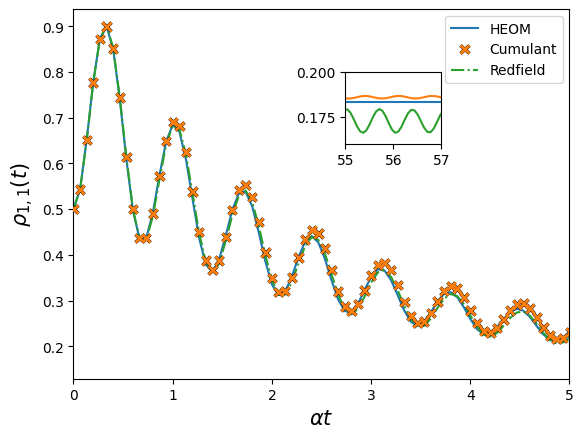

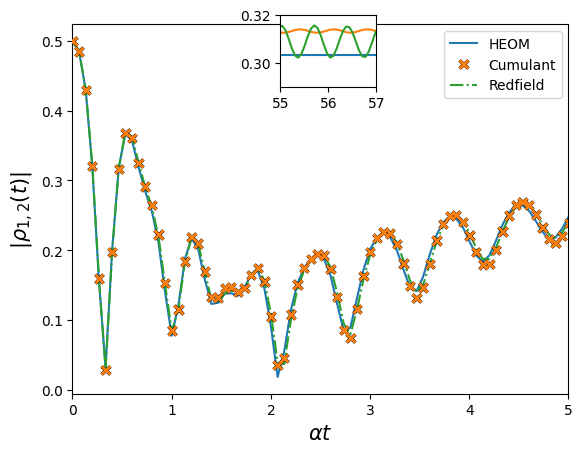

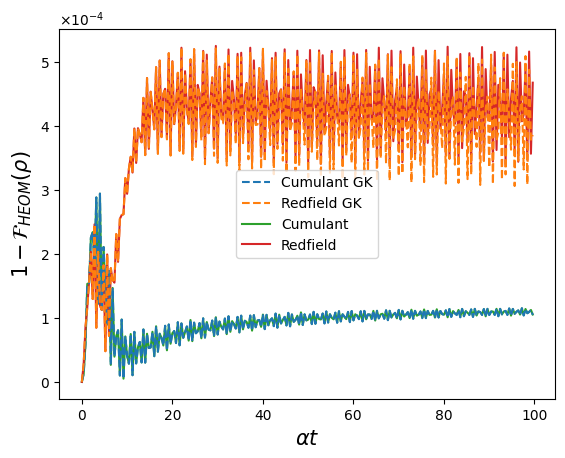

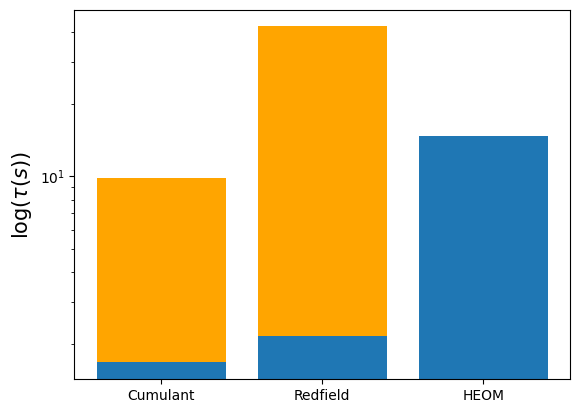

In [5]:
fig, ax = plt.subplots()
ax.plot(bathr.alpha * t, result.expect[0], label="HEOM")
ax.plot(
    bathr.alpha * t,
    [i[0, 0] for i in result_cum],
    label="Cumulant",
    linestyle="None",
    mew=2,
    path_effects=[pe.Stroke(linewidth=2.5, foreground="k"), pe.Normal()],
    zorder=4,
    marker="x",
)
ax.plot(bathr.alpha * t, [i[0, 0] for i in result_red], "-.", label="Redfield")

ax.legend()
ax.set_xlabel(r"$\alpha t$", fontsize=15)
ax.set_ylabel(r"$\rho_{1,1}(t)$", fontsize=15)
ax.set_xlim(0, 5)

# Add inset
inset = fig.add_axes([0.55, 0.6, 0.15, 0.15])  # [left, bottom, width, height]
inset.plot(bathr.alpha * t, result.expect[0])
inset.plot(bathr.alpha * t, [i[0, 0] for i in result_cum21])
inset.plot(bathr.alpha * t, [i[0, 0] for i in result_red])
inset.set_xlim(55, 57)  # Specify inset xlim
inset.set_ylim(0.16, 0.2)  # Specify inset ylim
inset.xaxis.set_major_locator(plt.MaxNLocator(2))
inset.yaxis.set_major_locator(plt.MaxNLocator(2))

plt.show()


fig, ax = plt.subplots()
ax.plot(bathr.alpha * t, np.abs(result.expect[1]), label="HEOM")
ax.plot(
    bathr.alpha * t,
    np.abs([i[0, 1] for i in result_cum]),
    label="Cumulant",
    linestyle="None",
    mew=2,
    path_effects=[pe.Stroke(linewidth=2.5, foreground="k"), pe.Normal()],
    zorder=4,
    marker="x",
)
ax.plot(bathr.alpha * t, np.abs([i[0, 1] for i in result_red]), "-.", label="Redfield")
ax.legend()
ax.set_xlim(0, 5)
ax.set_xlabel(r"$\alpha t$", fontsize=15)
ax.set_ylabel(r"$| \rho_{1,2}(t) |$", fontsize=15)
# Add inset
inset = fig.add_axes([0.45, 0.75, 0.15, 0.15])  # [left, bottom, width, height]
inset.plot(bathr.alpha * t, np.abs(result.expect[1]))
inset.plot(bathr.alpha * t, np.abs([i[0, 1] for i in result_cum21]))
inset.plot(bathr.alpha * t, np.abs([i[0, 1] for i in result_red]))
inset.set_xlim(55, 57)  # Specify inset xlim
inset.set_ylim(0.29, 0.32)  # Specify inset ylim
inset.xaxis.set_major_locator(plt.MaxNLocator(2))
inset.yaxis.set_major_locator(plt.MaxNLocator(2))

plt.show()

fid_red = [
    1 - qt.fidelity(result.states[i], qt.Qobj(result_red2[i])) for i in range(len(t))
]
fid_cum = [
    1 - qt.fidelity(result.states[i], qt.Qobj(result_cum[i])) for i in range(len(t))
]
fid_red_int = [
    1 - qt.fidelity(result.states[i], qt.Qobj(result_red[i])) for i in range(len(t))
]
fid_cum_int = [
    1 - qt.fidelity(result.states[i], qt.Qobj(result_cum21[i])) for i in range(len(t))
]
down = 6  # downsample the fidelity for better visualization
plt.plot(
    bathr.alpha * t[::down],
    fid_cum_int[::down],
    "--",
    label="Cumulant GK",
    markevery=10,
    zorder=4,
)
plt.plot(
    bathr.alpha * t[::down],
    fid_red_int[::down],
    "--",
    label="Redfield GK",
    markevery=10,
    zorder=4,
)
plt.plot(bathr.alpha * t[::down], fid_cum[::down], label="Cumulant")
plt.plot(bathr.alpha * t[::down], fid_red[::down], label="Redfield")
plt.legend()
ax = plt.gca()

ax.ticklabel_format(axis="y", style="sci", scilimits=(-4, -4), useMathText=True)


plt.xlabel(r"$\alpha t$", fontsize=15)
plt.ylabel(r"$1-\mathcal{F}_{HEOM}(\rho)$", fontsize=15)

plt.show()
methods2 = ["Cumulant", "Redfield"]
plt.bar(
    methods2, np.array([end_cum2 - end_cum, (end_redfield2 - end_cum2)]), color="orange"
)
methods2 = ["HEOM", "Cumulant", "Redfield"]
plt.bar(methods2, [end_heom - start, end_cum - end_heom, end_redfield - end_cum3])
plt.yscale("log")
plt.ylabel(r"$\log(\tau (s))$", fontsize=15)

plt.show()